In [1]:
import os
os.chdir("..")

In [2]:
from src.data.data_process import DataReg
import polars as pl
import requests
import bambi as bmb
import geopandas as gpd
from pysal.lib import weights
from shapely import wkt
import pandas as pd
import arviz as az
import matplotlib.dates as mdates
import numpy as np
import causalpy as cp
import matplotlib.pyplot as plt
dr = DataReg()

In [4]:
df_qcew = dr.base_data().with_columns(
    treatment=pl.when(pl.col("year") >= 2023).then(True).otherwise(False)
)
df_dp03 = dr.pull_dp03()
pr_zips = gpd.GeoDataFrame(dr.make_spatial_table().df())
pr_zips["geometry"] = pr_zips["geometry"].apply(wkt.loads)
pr_zips = pr_zips.set_geometry("geometry")
pr_zips["zipcode"] = pr_zips["zipcode"].astype(str)

df = df_qcew.join(df_dp03, on=["zipcode","year"], how="inner")
df = pr_zips.join(
    df_qcew.to_pandas().set_index("zipcode"), on="zipcode", how="inner", validate="1:m"
        ).reset_index(drop=True)
df = df.sort_values("year").reset_index(drop=True)
df_qcew

year,qtr,sector,zipcode,mw_industry,total_employment,min_wage,k_index,treatment
i32,i32,str,str,f64,f64,f64,f64,bool
2015,4,"""42""","""00968""",16134.852691,37.658333,3770.0,0.233656,false
2018,2,"""61""","""00605""",5794.489584,239.0,3770.0,0.650618,false
2002,2,"""51""","""00754""",6020.916667,2.5,2678.0,0.444783,false
2006,2,"""11""","""00922""",2005.581818,28.5,2678.0,1.335273,false
2004,2,"""53""","""00956""",4514.096078,8.447917,2678.0,0.593253,false
…,…,…,…,…,…,…,…,…
2009,1,"""48""","""00959""",6238.061869,9.033333,2678.0,0.4293,false
2016,4,"""32""","""00706""",6956.637931,38.666667,3770.0,0.541928,false
2023,2,"""81""","""00682""",6190.590116,16.166667,4420.0,0.713987,true


In [9]:
sector_df = df[(df["sector"] == "61")].reset_index(drop=True)
y = sector_df["total_employment"].values.reshape(-1,1)
w = weights.KNN.from_dataframe(sector_df, k=5)
reg = sector_df
reg["w_emplyment"] = weights.lag_spatial(w,y) 
reg

/home/ouslan/Documents/Github/pr-salaries/.venv/lib/python3.13/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 119 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


,zipcode,geometry,year,qtr,sector,mw_industry,total_employment,min_wage,k_index,treatment,w_emplyment
0,00794,"POLYGON ((-66.3739 18.18232, -66.37387 18.1824...",2002,3,61,2241.044444,45.000000,2678.0,1.194979,False,1131.188889
1,00704,"POLYGON ((-66.26921 17.98172, -66.2679 17.9829...",2002,3,61,2350.870130,25.666667,2678.0,1.139153,False,169.666667
2,00907,"POLYGON ((-66.11836 18.45493, -66.11605 18.455...",2002,3,61,4542.951919,32.466667,2678.0,0.589485,False,212.444444
3,00738,"POLYGON ((-65.75359 18.29676, -65.75173 18.298...",2002,1,61,2865.086736,34.916667,2678.0,0.934701,False,395.604257
4,00704,"POLYGON ((-66.26921 17.98172, -66.2679 17.9829...",2002,2,61,2931.300000,26.666667,2678.0,0.913588,False,169.666667
...,...,...,...,...,...,...,...,...,...,...,...
9704,00727,"POLYGON ((-66.11792 18.21008, -66.11764 18.210...",2024,1,61,3055.115385,26.000000,5460.0,1.787167,True,144.166667
9705,00705,"POLYGON ((-66.32085 18.12611, -66.32003 18.127...",2024,2,61,5581.686260,228.333333,5460.0,0.978199,True,648.333333
9706,00659,"POLYGON ((-66.83866 18.48377, -66.8386 18.4838...",2024,2,61,3828.576570,79.055556,5460.0,1.426117,True,463.444444
9707,00791,"POLYGON ((-65.87775 18.12716, -65.87772 18.127...",2024,1,61,6915.265632,158.047619,5460.0,0.789558,True,431.619048


In [10]:
# Assuming `reg` is your DataFrame and you want to set the 'year' column as a datetime index
data = reg.copy()
data = data.drop("geometry", axis=1)
# data = data.drop("sector", axis=1)
# data = data.drop("treatment", axis=1)
data['date'] = data['year'] * 10 + data['qtr']
data

,zipcode,year,qtr,sector,mw_industry,total_employment,min_wage,k_index,treatment,w_emplyment,date
0,00794,2002,3,61,2241.044444,45.000000,2678.0,1.194979,False,1131.188889,20023
1,00704,2002,3,61,2350.870130,25.666667,2678.0,1.139153,False,169.666667,20023
2,00907,2002,3,61,4542.951919,32.466667,2678.0,0.589485,False,212.444444,20023
3,00738,2002,1,61,2865.086736,34.916667,2678.0,0.934701,False,395.604257,20021
4,00704,2002,2,61,2931.300000,26.666667,2678.0,0.913588,False,169.666667,20022
...,...,...,...,...,...,...,...,...,...,...,...
9704,00727,2024,1,61,3055.115385,26.000000,5460.0,1.787167,True,144.166667,20241
9705,00705,2024,2,61,5581.686260,228.333333,5460.0,0.978199,True,648.333333,20242
9706,00659,2024,2,61,3828.576570,79.055556,5460.0,1.426117,True,463.444444,20242
9707,00791,2024,1,61,6915.265632,158.047619,5460.0,0.789558,True,431.619048,20241


In [11]:
model = bmb.Model("total_employment ~ k_index + date + (1 + k_index|zipcode) + w_emplyment", data)
results = model.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, k_index, date, w_emplyment, 1|zipcode_sigma, 1|zipcode_offset, k_index|zipcode_sigma, k_index|zipcode_offset]
/usr/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=157635) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=157635) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=157635) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Output()

/usr/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=157635) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/home/ouslan/Documents/Github/pr-salaries/.venv/lib/python3.13/site-packages/pymc/sampling/forward.py:427: DeprecationWarning: The samples argument has been deprecated in favor of draws. Use draws=5000 going forward.
  warnings.warn(
Sampling: [1|zipcode_sigma, Intercept, date, k_index, k_index|zipcode_sigma, sigma, w_emplyment]


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'k_index'}>],
       [<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'w_emplyment'}>,
        <Axes: title={'center': '1|zipcode_sigma'}>],
       [<Axes: title={'center': 'k_index|zipcode_sigma'}>, <Axes: >,
        <Axes: >]], dtype=object)

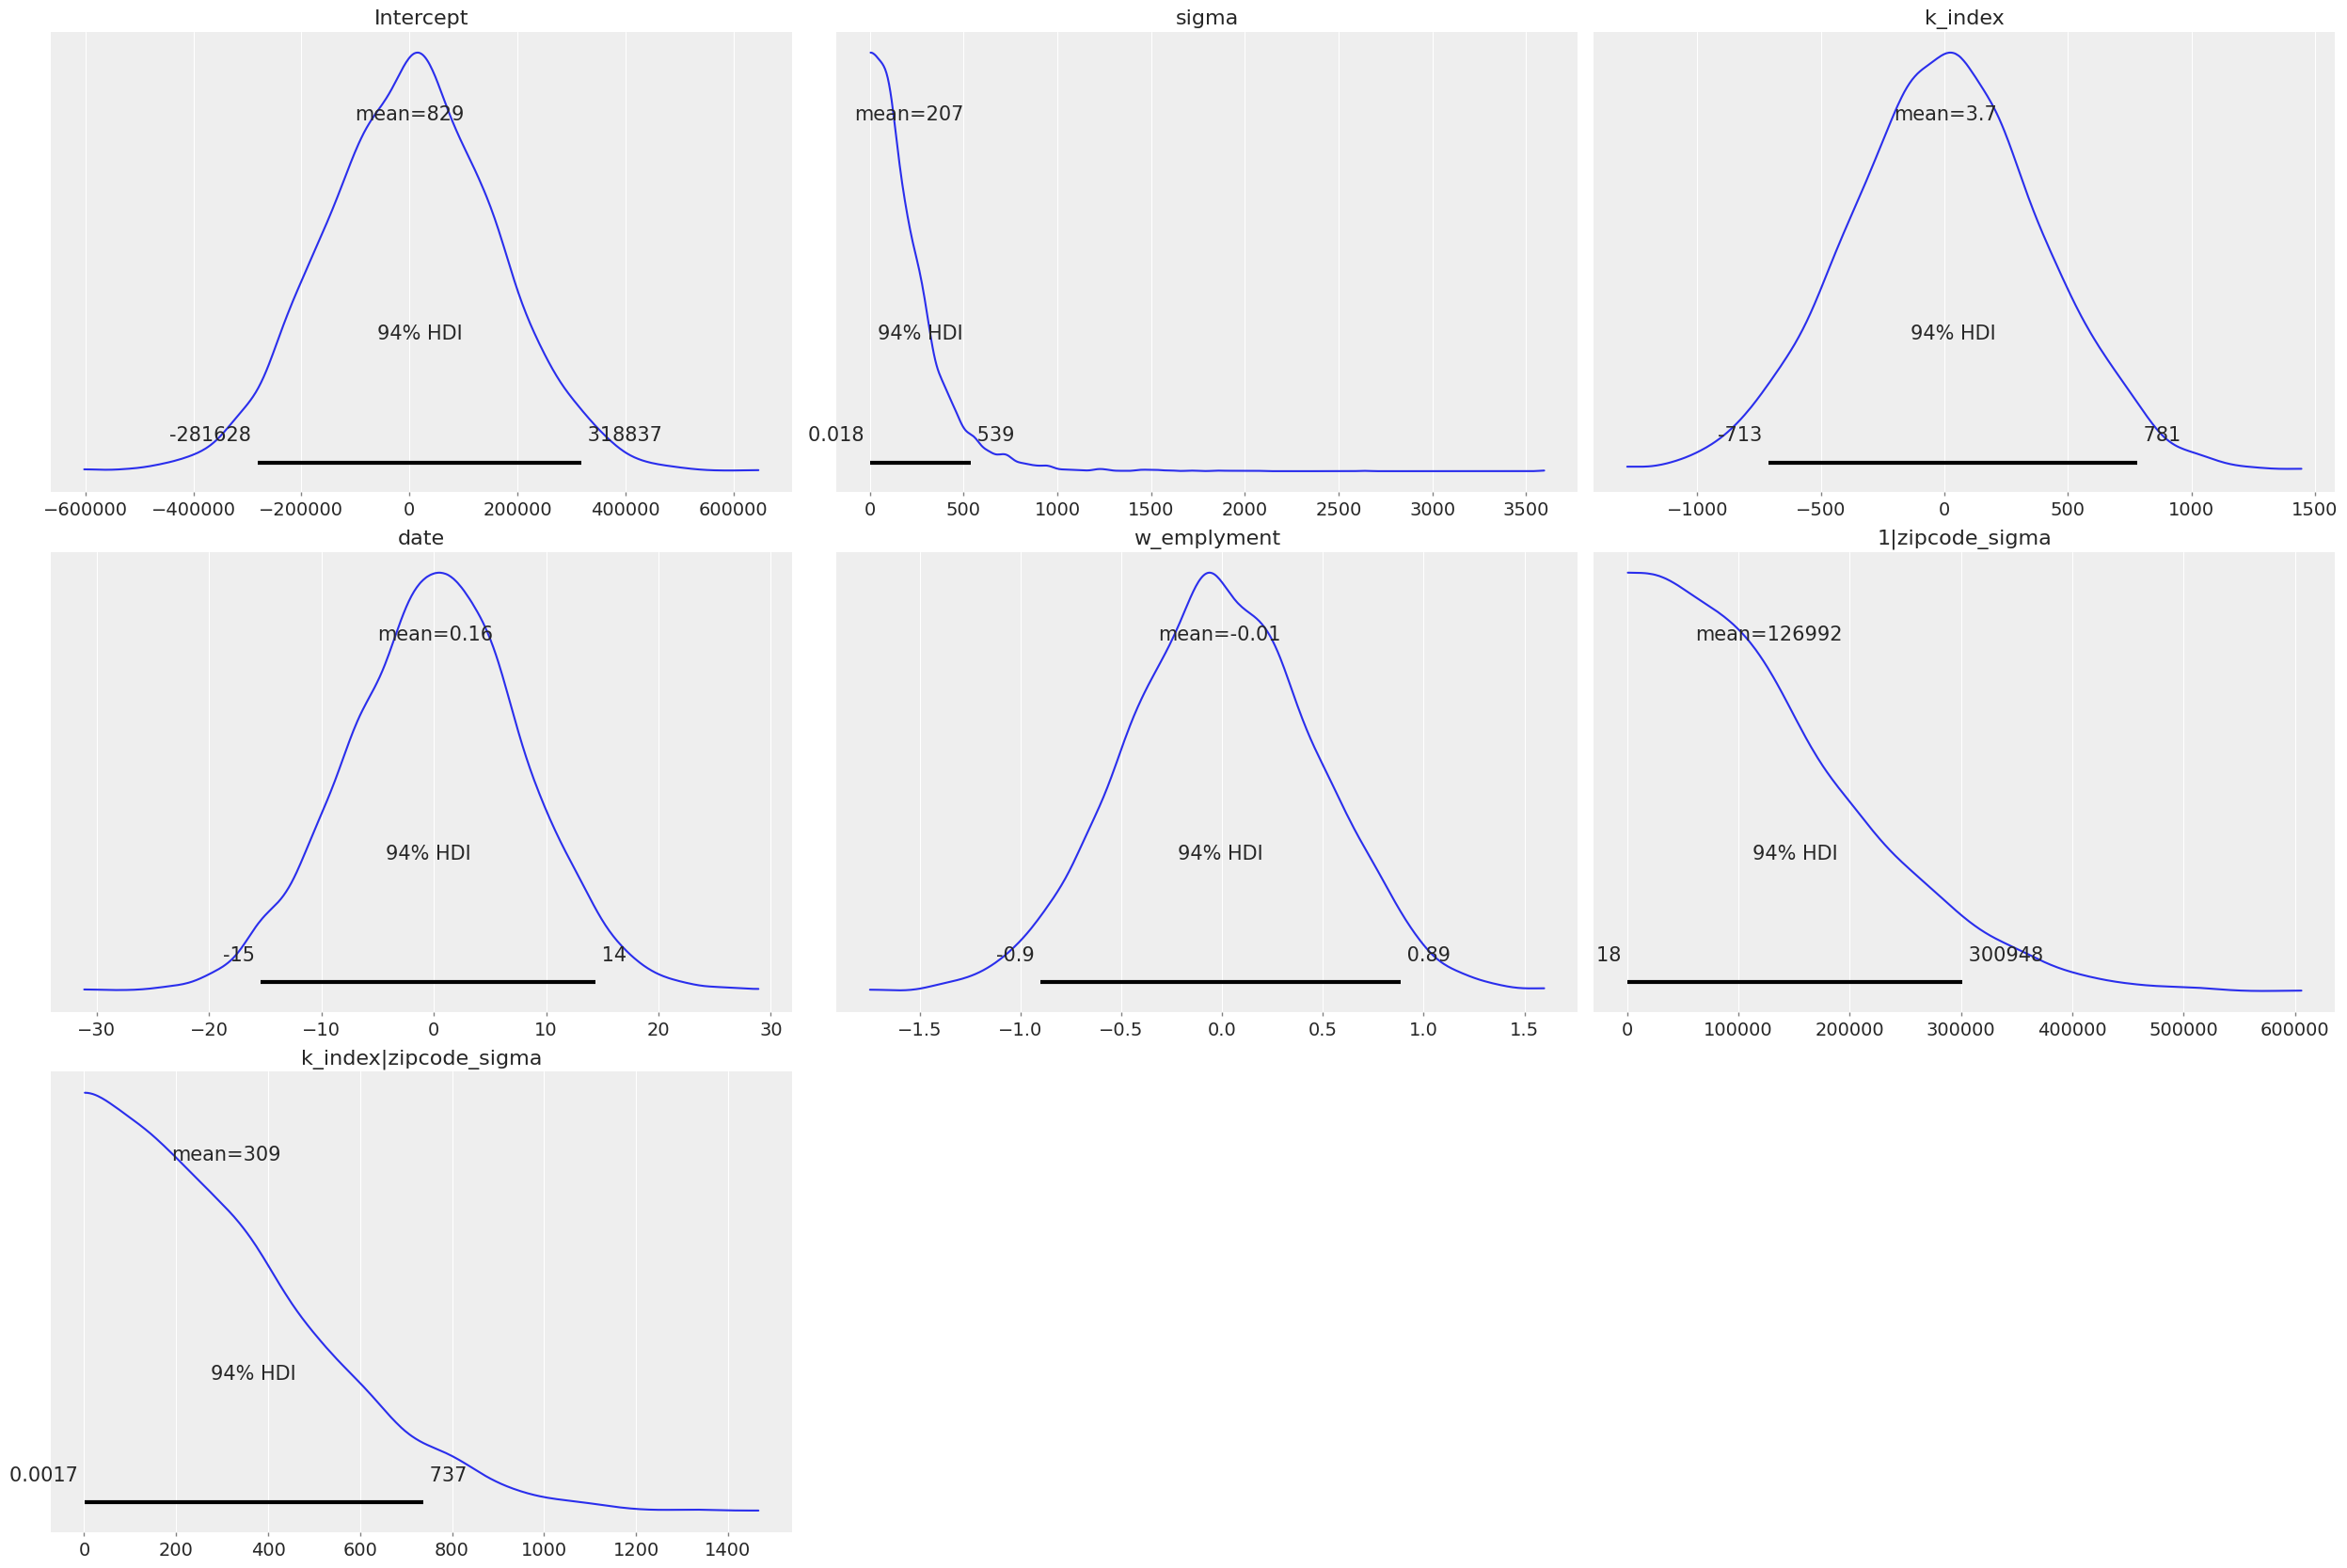

In [12]:
model.plot_priors()

array([[<Axes: title={'center': '1|zipcode'}>,
        <Axes: title={'center': '1|zipcode'}>],
       [<Axes: title={'center': '1|zipcode_sigma'}>,
        <Axes: title={'center': '1|zipcode_sigma'}>],
       [<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'date'}>],
       [<Axes: title={'center': 'k_index'}>,
        <Axes: title={'center': 'k_index'}>],
       [<Axes: title={'center': 'k_index|zipcode'}>,
        <Axes: title={'center': 'k_index|zipcode'}>],
       [<Axes: title={'center': 'k_index|zipcode_sigma'}>,
        <Axes: title={'center': 'k_index|zipcode_sigma'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'w_emplyment'}>,
        <Axes: title={'center': 'w_emplyment'}>]], dtype=object)

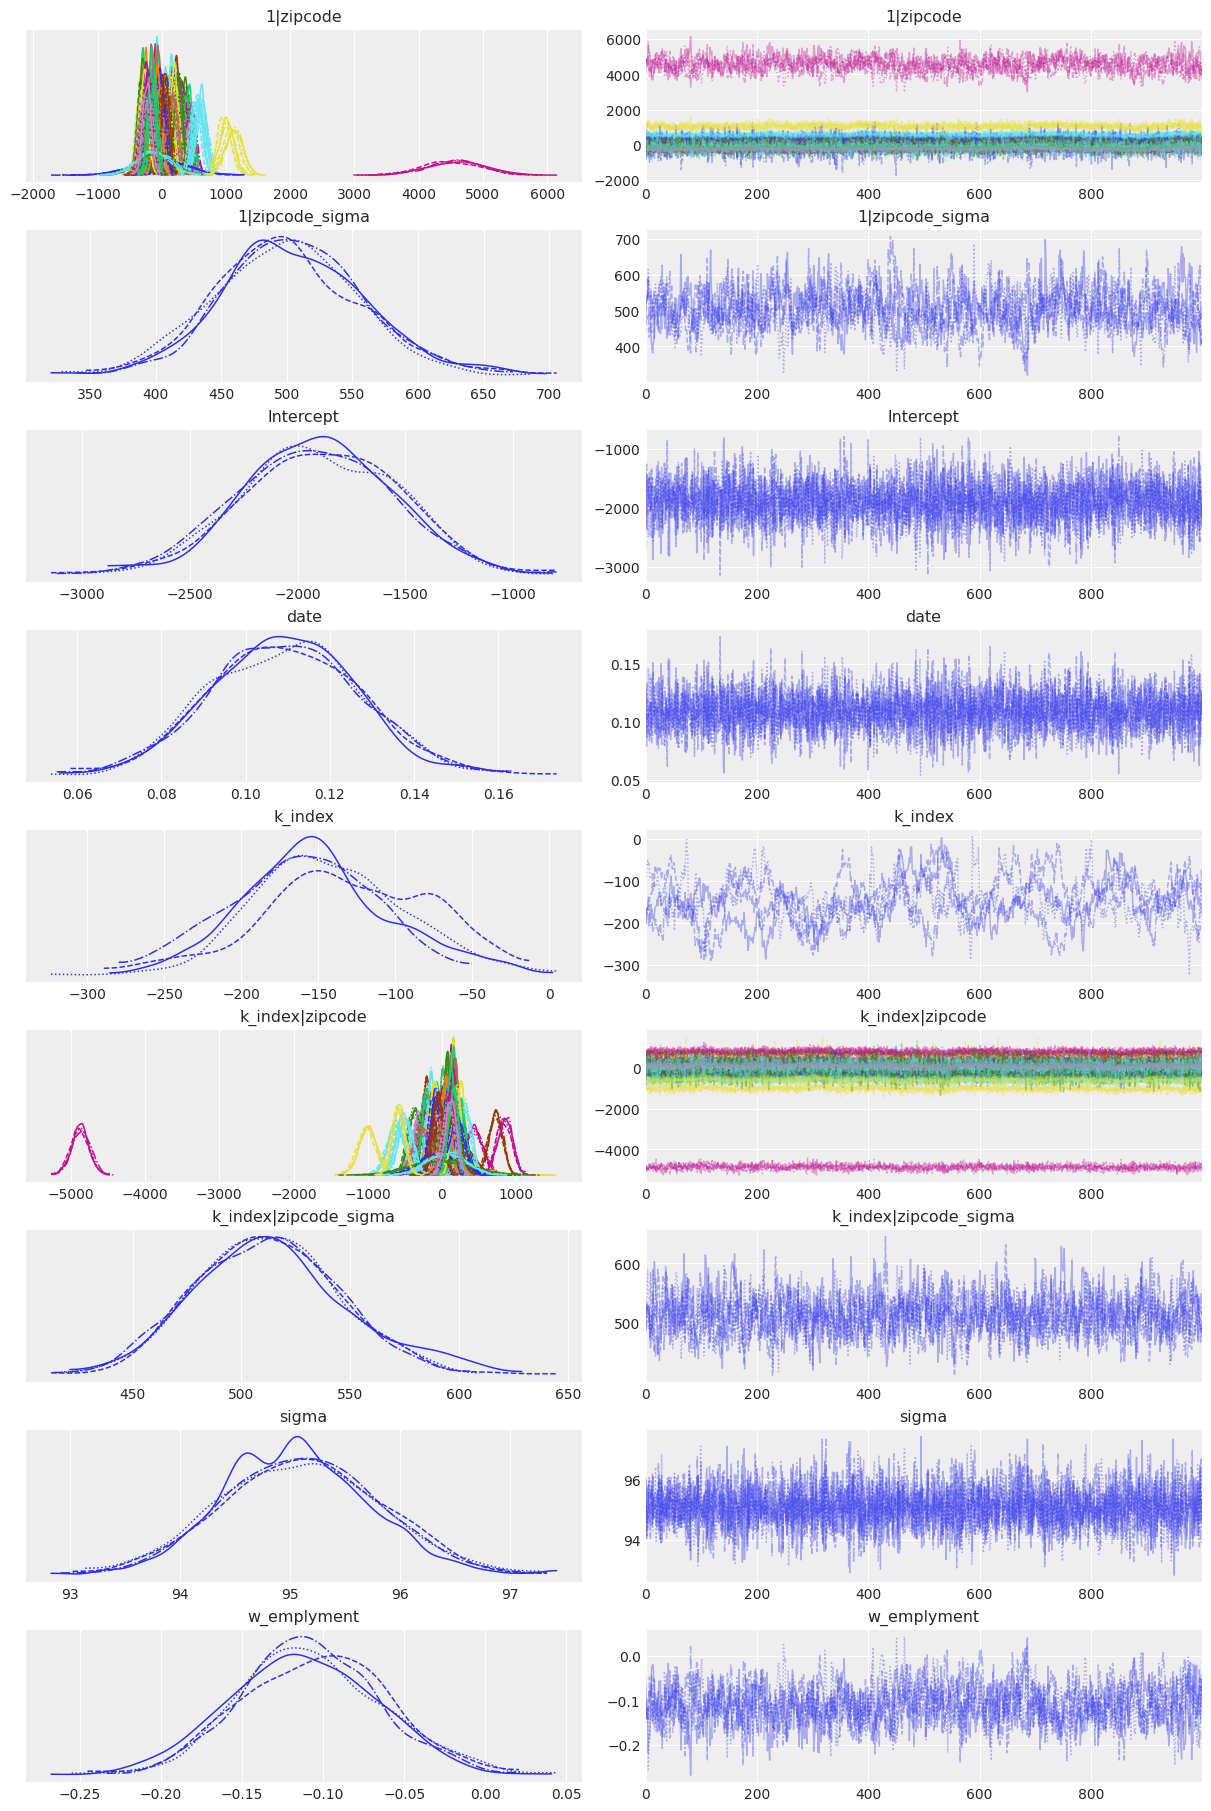

In [13]:
# Plot posteriors
az.plot_trace(
    results,
    compact=True,
)

In [ ]:
ppc = model.predict(results, kind="pps", inplace=False)
az.plot_ppc(model)


In [14]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|zipcode[00601],227.937,67.074,105.350,352.679,7.783,2.281,76.0,342.0,1.06
1|zipcode[00602],-166.132,91.131,-338.298,1.356,7.625,1.940,143.0,750.0,1.03
1|zipcode[00603],-90.059,90.637,-268.176,66.542,8.890,1.923,104.0,758.0,1.04
1|zipcode[00606],-104.952,56.481,-205.495,0.408,8.750,2.372,42.0,239.0,1.09
1|zipcode[00610],93.146,71.763,-35.833,229.076,7.907,2.021,82.0,459.0,1.05
...,...,...,...,...,...,...,...,...,...
k_index|zipcode[00985],146.624,67.733,18.229,269.353,4.950,1.795,188.0,508.0,1.04
k_index|zipcode[00987],109.328,77.890,-38.054,249.508,5.226,1.905,222.0,710.0,1.03
k_index|zipcode_sigma,512.573,33.504,451.312,576.715,1.020,0.584,1077.0,1816.0,1.00
sigma,95.087,0.704,93.857,96.500,0.010,0.012,4560.0,2967.0,1.00


In [ ]:
preds = model.predict(results)  # In-sample predicted values
df["predicted_y"] = preds

In [ ]:
ppc = model.predict(results, kind="pps", inplace=False)

# Compute Bayesian R² manually from observed and predicted values
r2_vals = az.r2_score(y=ppc.observed_data["total_employment"],
                      y_hat=ppc.posterior_predictive["total_employment"])

print(r2_vals.mean())  